# 1.1

In [108]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold  # For creating folds

# Global settings
dataset_dir = 'dataset'  # Update with your actual path
image_size = (32, 32)  # Update to desired resolution

## Loading Images

First of all, we have to create our (n,x,y,3) array containing all data. In our case, the size of it is (25,32,32,3). We also load the labels, but those will not be neccessary for any calculation whatsoever. 

In [109]:
def load_images_pillow(dataset_dir, image_size=(32, 32)):
    images = []
    labels = []
    categories = os.listdir(dataset_dir)
    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path, file_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(category)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

images_array, labels_array = load_images_pillow(dataset_dir, image_size=(32, 32))
print(f"Loaded {images_array.shape[0]} images with labels {set(labels_array)}")

Loaded 25 images with labels {np.str_('frogs'), np.str_('apples'), np.str_('cars'), np.str_('cats'), np.str_('dogs')}


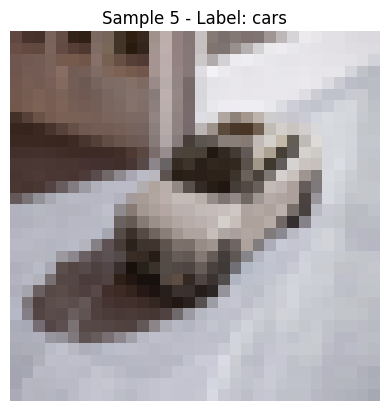

In [110]:
def PlotSample(index):
    plt.imshow(cv2.cvtColor(images_array[index], cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {index} - Label: {labels_array[index]}")
    plt.axis('off')
    plt.show()

PlotSample(5)

# Test the function
# i=0
# while i<25:
#     PlotSample(i)
#     i=i+1

## Flattening the image

Note how we reshape the images from the array. Here, each image is a row, where all pixels are flattened. From the print below, we see that we have our total images (25) and the total size of our 1D vector (3072 pixels). We will read this by the fact that each row is one image, and each column represents a pixel in each image. As for the reason why the size of each row is 3072, it's because of the fact that we are including 3 colour types, and the size of each image is 32x32. By doing the math, we get: 3x32x32=3072 pixels.

In [111]:
flattened_images = images_array.reshape(images_array.shape[0], -1)
#flattened_images = images_array.reshape(-1,3)

print(f"Flattened images shape: {flattened_images.shape}")

Flattened images shape: (25, 3072)


I want to note that we are representing each image by row. We can represent this differently by using the commented line, where we would combine all images by column, and instead divide them for each colour (3). This could be useful for tasks like clustering similar pixel colours or analyzing the general colour distribution in the dataset.

I also want to note that the original whitening function given by the article does not work with the flattening I'm using as of now (25, 3072), but it works for the pixel colour distribution which is given by the commented line, resulting in the shape (25600,3).

## Visualize data and calculate covariance

The code for plotDataAndCov is taken from https://hadrienj.github.io/posts/Preprocessing-for-deep-learning/ which is given by the instructions.

Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


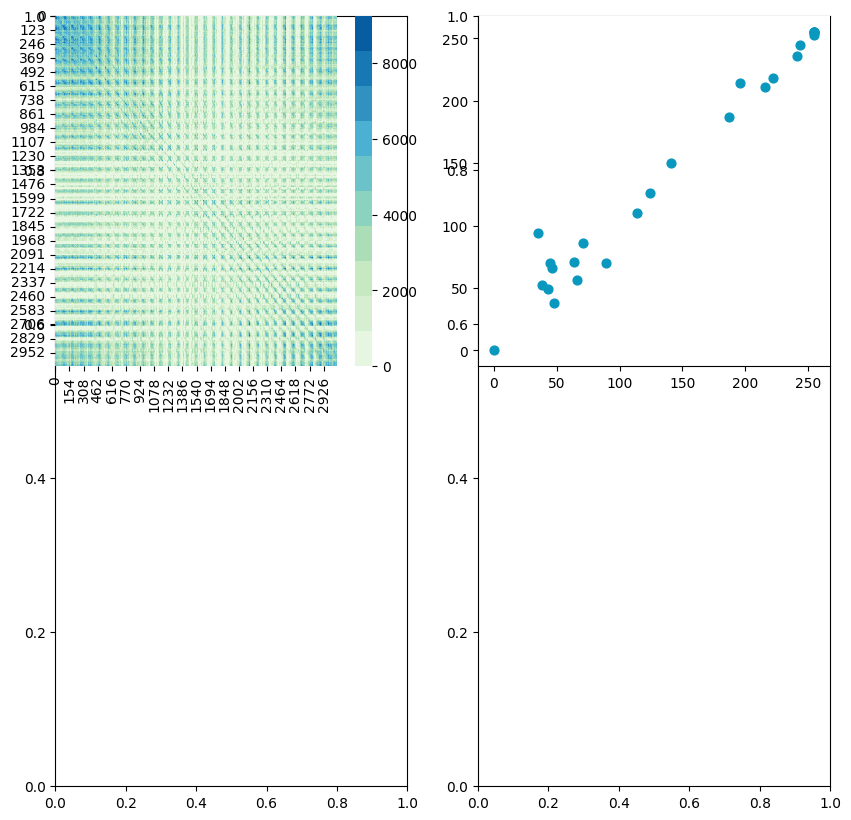

In [112]:
import seaborn as sns

def plotDataAndCov(data):
    ACov = np.cov(data, rowvar=False, bias=True)
    print('Covariance matrix:\n', ACov)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    ax0 = plt.subplot(2, 2, 1)

    # Choosing the colorus
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    ax1 = plt.subplot(2, 2, 2)

    # data can include the colours
    if data.shape[1]==3:
        c=data[:,2]
    else:
        c="#0A98BE"
    ax1.scatter(data[:,0], data[:,1], c=c, s=40)

    # Remove the top and right axes from the data plot
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

# Call with flattened_images
plotDataAndCov(flattened_images)

## Mean normalization

We center the data in order to remove biases, but according to the resulting matrix, it doesn't seem to change. Generally, this is done to help the model learn faster by starting closer to a real/optimal solution.

Before:


Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


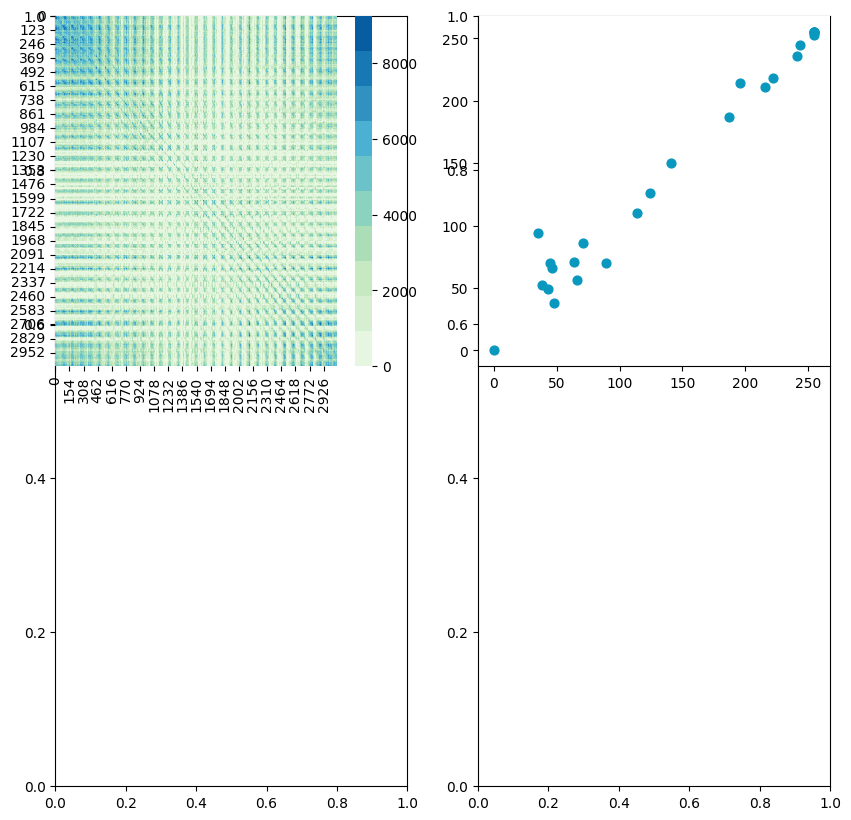

After:


Covariance matrix:
 [[8051.84   7584.984  7988.288  ... 5340.232  5191.488  6062.64  ]
 [7584.984  7338.9856 7661.1552 ... 5010.3328 5019.8832 5768.504 ]
 [7988.288  7661.1552 8627.0784 ... 5339.6976 5165.6944 6383.128 ]
 ...
 [5340.232  5010.3328 5339.6976 ... 5812.0064 5704.0016 6140.112 ]
 [5191.488  5019.8832 5165.6944 ... 5704.0016 5831.4304 6166.528 ]
 [6062.64   5768.504  6383.128  ... 6140.112  6166.528  7149.28  ]]


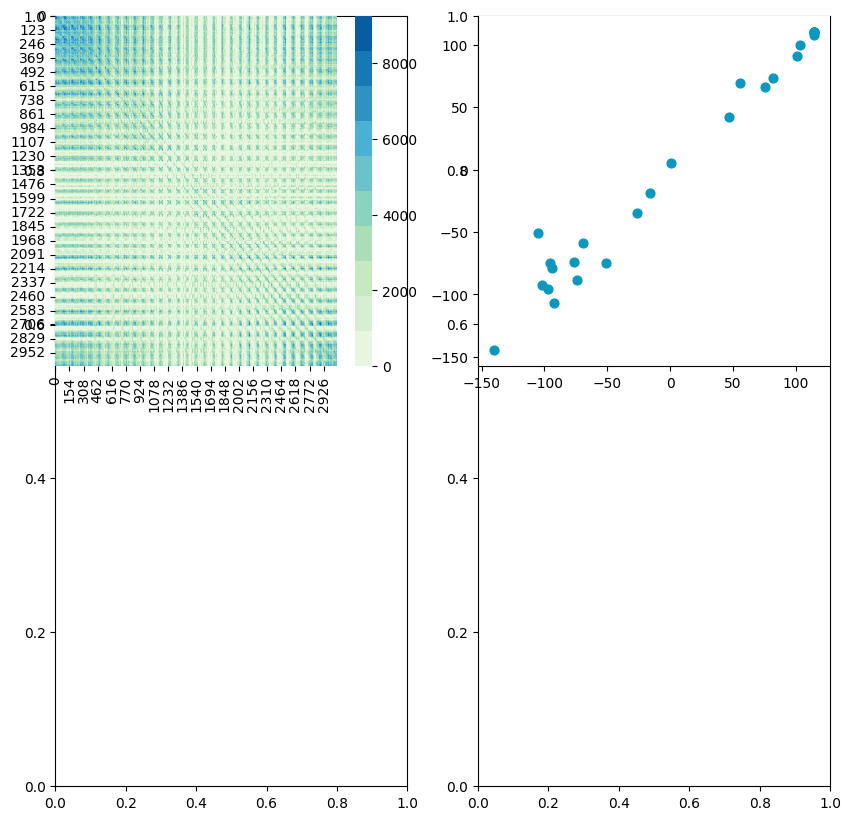

In [113]:
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

centeredMatrix = center(flattened_images)

print('Before:\n\n')

plotDataAndCov(flattened_images)
plt.show()
plt.close()

print('After:\n\n')

plotDataAndCov(centeredMatrix)
plt.show()
plt.close()


Since we've printed before and after, we see that there is no visible difference in this case. We note that this is not always the case for all data.

## Standardize

We standardize the data in order to keep our pixels (features) on the same scale, which is important for stability. The result of this processing can be seen both on the axis, but also on the resulting matrix.

Covariance matrix:
 [[1.         0.98670899 0.95846062 ... 0.78063769 0.75762926 0.79906675]
 [0.98670899 1.         0.96281838 ... 0.76715923 0.76734037 0.79636842]
 [0.95846062 0.96281838 1.         ... 0.75408751 0.72829829 0.81277536]
 ...
 [0.78063769 0.76715923 0.75408751 ... 1.         0.97978108 0.95253753]
 [0.75762926 0.76734037 0.72829829 ... 0.97978108 1.         0.95504098]
 [0.79906675 0.79636842 0.81277536 ... 0.95253753 0.95504098 1.        ]]


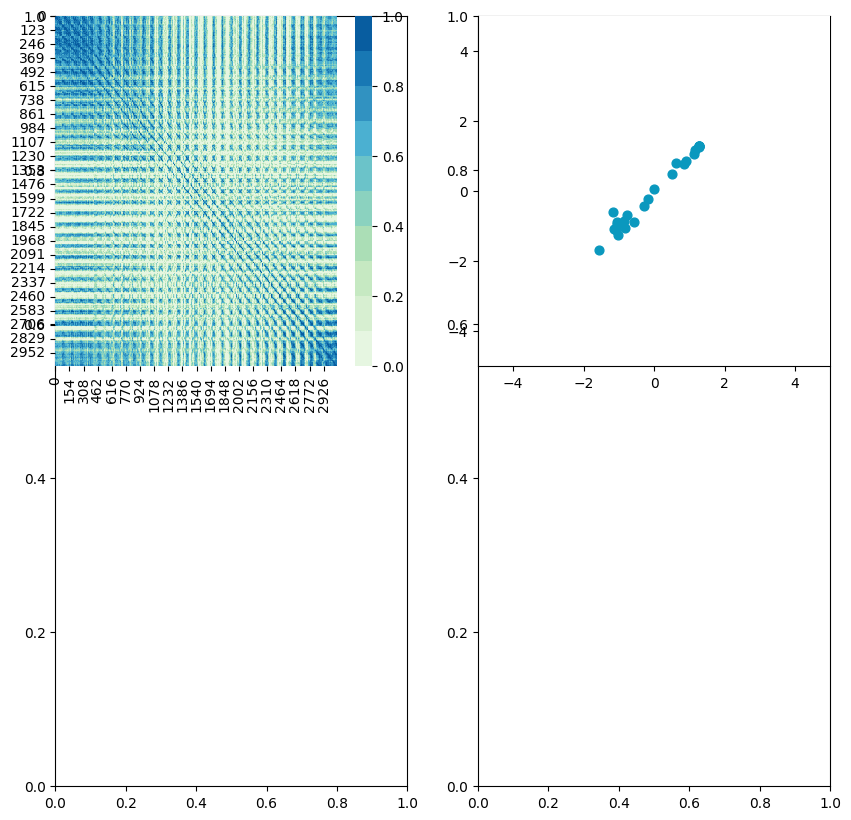

In [114]:
def standardize(X):
    newX = center(X)/np.std(X, axis = 0)
    return newX

#CStandardized = standardize(centeredMatrix)
standardizedMatrix = standardize(flattened_images)


plotDataAndCov(standardizedMatrix)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()


The result is to be expected: both axis follow the same pattern and both are centered around zero! Here we can see a large difference between the regular, flattened array and the resulting covariance matrix.

## Whitening

We are going to use the following steps for our resulting matrix:

1- Zero-center the data
2- Decorrelate the data
3- Rescale the data

## Zero-centering
To start things off, we can zero-center by simply using center(). This will result in our features centering around zero, which is needed for the later steps in the whitening.

## Decorrelating
We decorrelate the features in order to have no correlation between them. This, essentially, means that we rotate our data points.

In [115]:
def decorrelate(X):
    XCentered = center(X)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    return decorrelated

## Whitening

The given function for whitening looks like this, and was given by the referred article. Note that the steps above are all included in this simple function:

In [116]:
def whiten(X):
    XCentered = center(X)
    cov = XCentered.T.dot(XCentered)/float(XCentered.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

In [117]:
def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32, 32, 3))
    plt.show()
    plt.close()

## Whitening implementation

Now, since they showed a hands-on implementation of how this would look like with real images, I've implemented the steps taken by creating two functions: zca_whiten and rescale_for_visualization. As can be seen, each step is directly based off of the implementation given in the article.

In [118]:
def zca_whiten(X, epsilon=0.1):
    # Step 1: Normalize the dataset by dividing by 255 to bring values to [0, 1]
    X_norm = X / 255.0
    
    # Step 2: Center the data by subtracting the mean of each feature (pixel position)
    X_centered = X_norm - X_norm.mean(axis=0)
    
    # Step 3: Compute the covariance matrix of the centered data
    cov = np.cov(X_centered, rowvar=False)
    
    # Step 4: Perform Singular Value Decomposition (SVD) on the covariance matrix
    U, S, V = np.linalg.svd(cov)
    
    # Step 5: Construct the ZCA whitening matrix
    zca_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    
    # Step 6: Apply the ZCA whitening matrix to the centered data
    X_ZCA = X_centered @ zca_matrix
    
    return X_ZCA

def rescale_for_visualization(X):
    return (X - X.min()) / (X.max() - X.min())

And to prove it all works, the results can be seen below. 

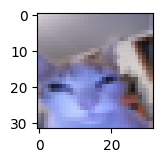

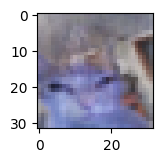

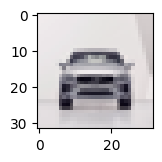

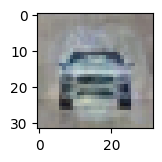

Covariance matrix:
 [[0.01720055 0.01563597 0.01380393 ... 0.00322306 0.00226811 0.00314105]
 [0.01563597 0.01557991 0.01384441 ... 0.00256407 0.00275591 0.00359388]
 [0.01380393 0.01384441 0.01707298 ... 0.00189997 0.00055159 0.00279598]
 ...
 [0.00322306 0.00256407 0.00189997 ... 0.00727874 0.00625121 0.00481009]
 [0.00226811 0.00275591 0.00055159 ... 0.00625121 0.00704641 0.00538677]
 [0.00314105 0.00359388 0.00279598 ... 0.00481009 0.00538677 0.00654999]]


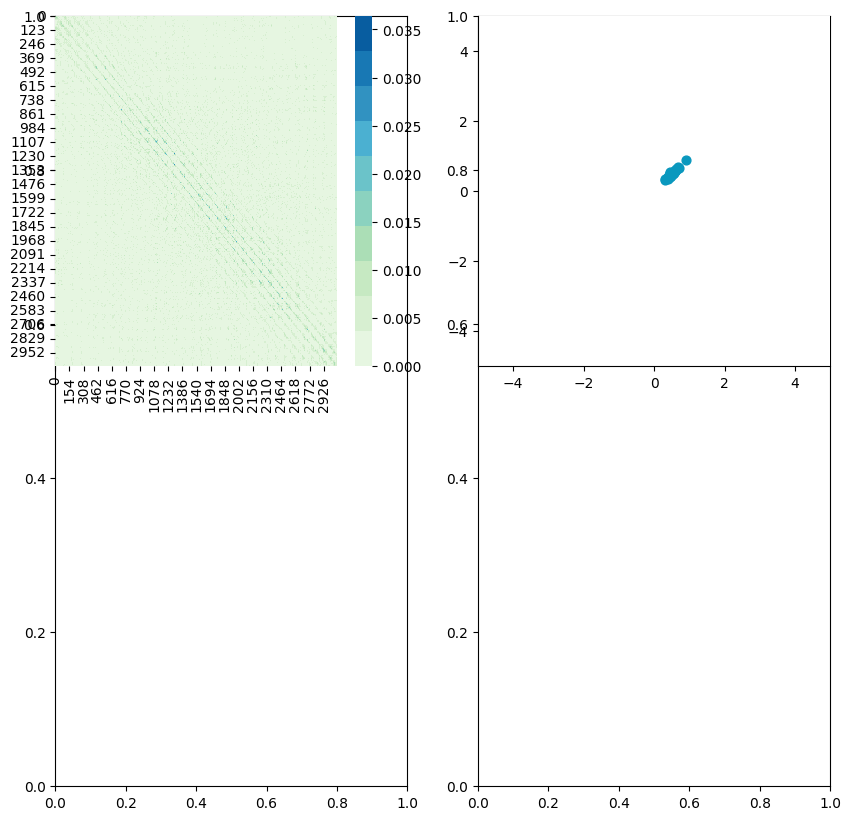

In [119]:
X_ZCA = zca_whiten(flattened_images)
X_ZCA_rescaled = rescale_for_visualization(X_ZCA)

# plotImage(images_array[12])
# plotImage(X_ZCA_rescaled[12, :])

plotImage(flattened_images[12, :])
plotImage(X_ZCA_rescaled[12, :])

plotImage(flattened_images[6])
plotImage(X_ZCA_rescaled[6])

plotDataAndCov(X_ZCA_rescaled)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()
plt.close()

We see that the resulting images are whitened, and by plotting the covariance vectors, it is zero-centered and as decorrelated as it can be.

# 1.2

First we load the data from vecs.npy. This loads the npy file and converts it to a dictionary so that we can access everything.

In [120]:
data = np.load("vecs.npy", allow_pickle=True).item()

print("data loaded successfully.")
print("available positions:", list(data.keys()))

position_key = '1_pos'
if position_key in data:
    print(f"sample of digits at {position_key}:", list(data[position_key].keys()))
    
    sample_embedding = np.array(data[position_key][0]) # <----- create numpy array
    print("shape of one sample embedding:", sample_embedding.shape)
else:
    print(f"position {position_key} not found in data.")

data loaded successfully.
available positions: ['1_pos', '2_pos', '3_pos', '4_pos', '5_pos', '6_pos', '7_pos', '8_pos', '9_pos']
sample of digits at 1_pos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
shape of one sample embedding: (122, 1024)


Shown above are some prints. I used them for debugging my code but they can prove useful either way. 

Now we want to extract the embeddings and labels for a position, e.g. 1_pos, as seen in my example in the code cell below. We loop through each digit and its embedding at the position. Here we handle the conversion from embedding to a numpy array. Note that we have now split embeddings and labels into seperate lists, just as the task stated.

In [121]:
def extract_embeddings_labels(data, position):
    position_key = f"{position}_pos"
    
    if position_key not in data:
        raise ValueError(f"Position {position_key} not founddd")
    
    embeddings = []
    labels = []
    for digit, embedding in data[position_key].items():
        embeddings.append(np.array(embedding)) 
        labels.append(digit)
    
    embeddings_array = np.vstack(embeddings) # <----------- 2D array of all embeddings
    labels_array = np.array(labels) # <----------- 1D array of all labels matching the embedding order (so that it actually makes sense) 
    
    return embeddings_array, labels_array

position = 1  # <------- arbitrary position 
embeddings_array, labels_array = extract_embeddings_labels(data, position)
print("embeddings shape:", embeddings_array.shape)
print("labels shape:", labels_array.shape)

embeddings shape: (1258, 1024)
labels shape: (10,)


Finally, we shuffle the data. Simply generate a permutation and apply it to both embeddings and labels. Using the same permutation allows our labels and embeddings to still match eachother, while still being shuffled. Below the method there's printouts to make sure everything has been handled correctly.

In [122]:
def shuffle_data_and_labels(embeddings, labels):
    permutation = np.random.permutation(len(labels))
    
    shuffled_embeddings = embeddings[permutation]
    shuffled_labels = labels[permutation]
    
    return shuffled_embeddings, shuffled_labels

print("original embeddings (first 5):\n", embeddings_array[:5])
print("\noriginal labels (first 5):\n", labels_array[:5])

shuffled_embeddings, shuffled_labels = shuffle_data_and_labels(embeddings_array, labels_array)

print("\nshuffled embeddings (first 5):\n", shuffled_embeddings[:5])
print("\nshuffled labels (first 5):\n", shuffled_labels[:5])

order_changed = not np.array_equal(embeddings_array, shuffled_embeddings) or not np.array_equal(labels_array, shuffled_labels)
print("\norder changed after shuffling:\n", order_changed)


original embeddings (first 5):
 [[-0.       -0.       -0.       ... -0.       -0.        9.227847]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]

original labels (first 5):
 [0 1 2 3 4]

shuffled embeddings (first 5):
 [[-0.0000000e+00 -0.0000000e+00 -4.2848642e-18 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00  9.2278471e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]

shuffled labels (first 5):
 [9 5 0 2 6]

order changed after 

# 2.1

In [123]:
from tensorflow.keras.datasets import mnist # type: ignore

(Xtr, Ltr), (X_test, L_test)=mnist.load_data()

In [124]:
Xtr.shape

(60000, 28, 28)

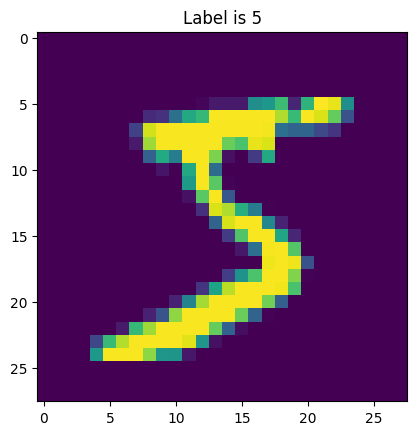

In [125]:
Image=Xtr[0,:,:]
Label=Ltr[0]


plt.title('Label is {Label}'.format(Label=Label))
plt.imshow(Image)

plt.show()
plt.close()


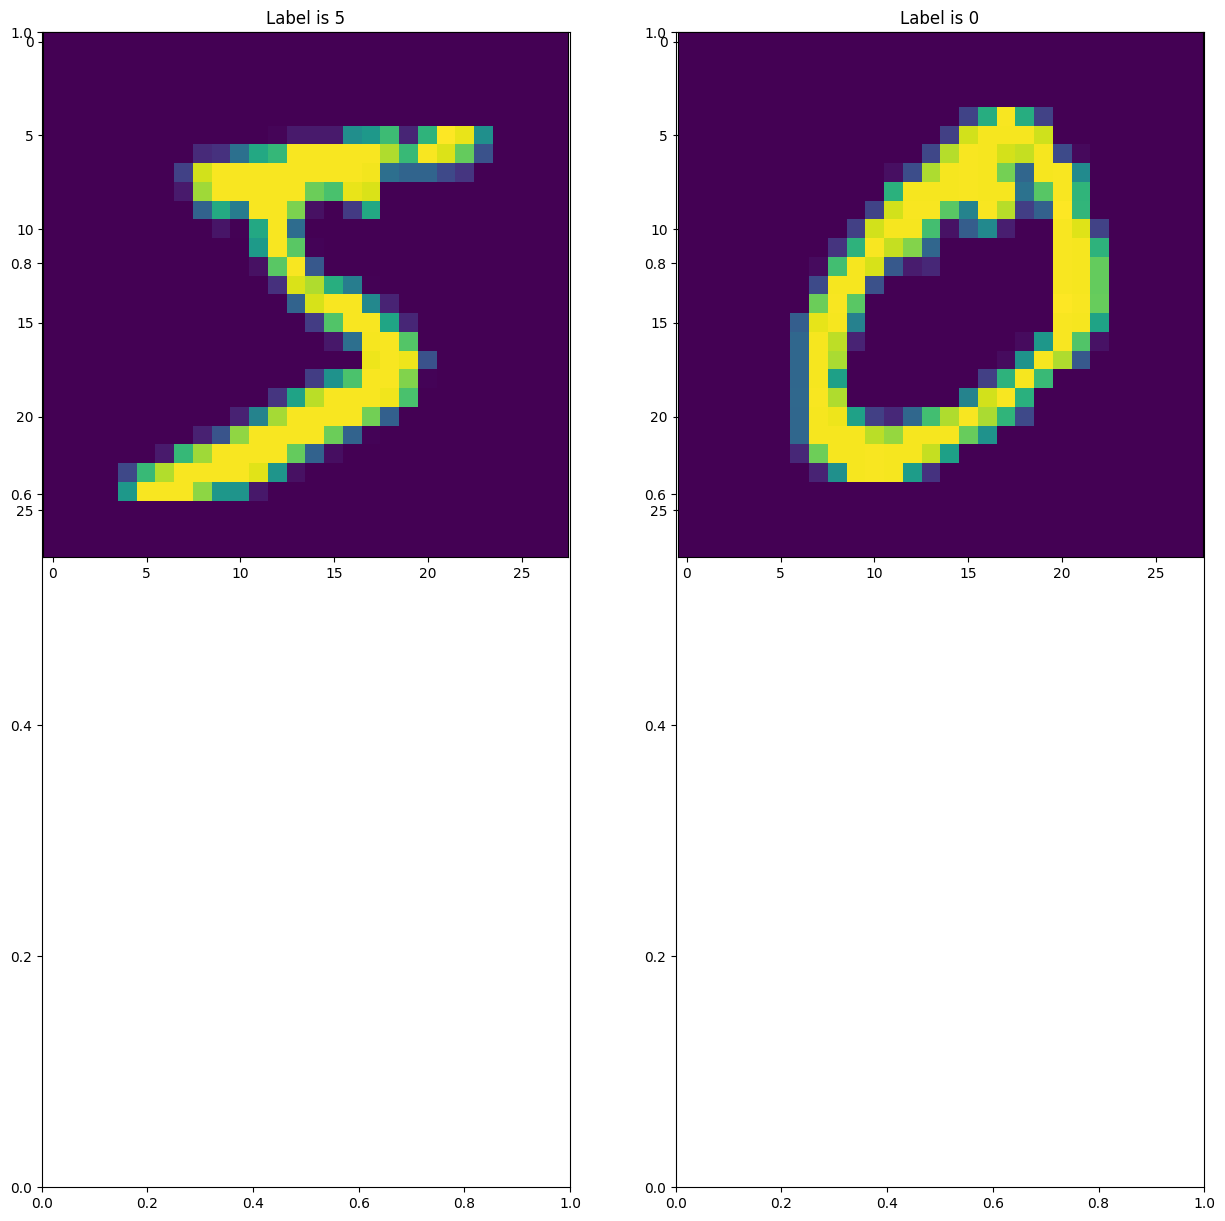

In [126]:
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax0=plt.subplot(2,2,1)
ax1=plt.subplot(2,2,2)

Image=Xtr[0,:,:]
Label=Ltr[0]
Image1=Xtr[1,:,:]
Label1=Ltr[1]


ax0.set_title('Label is {Label}'.format(Label=Label))
ax0.imshow(Image)
ax1.set_title('Label is {Label}'.format(Label=Label1))
ax1.imshow(Image1)


plt.show()
plt.close()

In [127]:
28*28

784

By printing Tr_set, we see that this is where the bug occured. By casting it as an integer instead, the calculations are performed as intended. The result can be seen in the accuracy output some cells below.

In [128]:
#Traing phase
num_sample=500
Tr_set=Xtr[:num_sample,:,:]
Ltr_set=Ltr[:num_sample]

#Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2])
#print(Tr_set)

Tr_set=Tr_set.reshape(num_sample,Tr_set.shape[1]*Tr_set.shape[2]).astype(int)
Tr_set.shape

(500, 784)

In [129]:
def predict(X):
    num_test=X.shape[0]
    Lpred=np.zeros(num_test, dtype=Ltr_set.dtype)
    
    for i in range(num_test):
        
        #distances=np.sum(np.abs(Tr_set-X[i,:]),axis=1) # L1

        distances=np.sqrt(np.sum(np.square(np.abs(Tr_set-X[i,:])), axis=1)) # L2
        
        min_index= np.argmin(distances)
        Lpred[i]=Ltr_set[min_index]
    return Lpred

In [130]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)

print("Accuracy:", np.mean(Labels_predicted==L_test))

Accuracy: 0.8294


For the L1 norm, our accuracy is 26.49%, and after modifying the code to account for the L2 norm, our accuracy is 19%. After fixing the bug present in the code, the accuracy for the L2 norm is now 82.94%, which is more in line with what we would expect.

Implementing k-NN could look something like:

In [ ]:
def kNN_predict(testSet, trainingSet, trainingLabel, k_nearest):
    numerable = testSet.shape[0]
    Lpred = np.zeros(numerable, dtype=trainingLabel.dtype)
    
    # cast as int to not get bugs like before
    testSet = testSet.astype(int)
    trainingSet = trainingSet.astype(int)

    for i in range(numerable):
        distances = np.sqrt(np.sum((trainingSet - testSet[i, :]) ** 2, axis=1)) # L2
        nearest_indices = np.argsort(distances)[:k_nearest]
        nearest_labels = trainingLabel[nearest_indices]
        label_counts = np.bincount(nearest_labels, minlength=10)
        
        # break ties if needed.
        if np.count_nonzero(label_counts == label_counts.max()) > 1:
            winner = trainingLabel[nearest_indices[0]]
        else:
            winner = np.argmax(label_counts)
        Lpred[i] = winner
    
    return Lpred

In [132]:
Test_images=X_test.reshape(X_test.shape[0],X_test.shape[1]* X_test.shape[2])
Labels_predicted=predict(Test_images)
k = 3
Labels_predicted_k=kNN_predict(Test_images, Tr_set, Ltr_set, k)

print("accuracy:", np.mean(Labels_predicted==L_test))
print(f'k-accuracy, with k={k}:', np.mean(Labels_predicted_k==L_test))

accuracy: 0.8294
k-accuracy, with k=3: 0.8189


# 2.2

Now we want to find the best value of 'k' using 3-fold cross-validation. We'll use L2 as specified.

In [ ]:
def find_optimal_k(training_set, training_labels, k_values, num_folds=3):
    best_k = None
    best_accuracy = 0
    accuracies_for_k = {k: [] for k in k_values}
    
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    
    for k in k_values:
        fold_accuracies = []
        
        for train_index, val_index in kf.split(training_set):
            X_train_fold, X_val_fold = training_set[train_index], training_set[val_index]
            y_train_fold, y_val_fold = training_labels[train_index], training_labels[val_index]
            
            predictions = kNN_predict(X_val_fold, X_train_fold, y_train_fold, k)
            
            accuracy = np.mean(predictions == y_val_fold)
            fold_accuracies.append(accuracy)
        
        avg_accuracy = np.mean(fold_accuracies)
        accuracies_for_k[k].append(avg_accuracy)
        
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_k = k
    
    return best_k, best_accuracy, accuracies_for_k



In [ ]:
k_values = list(range(1, 11)) # <--- this is the range of the k values. can be adjusted but 1 to 11 is more than enough for these tests

# find the optimal k
best_k, best_accuracy, accuracies_for_k = find_optimal_k(Tr_set, Ltr_set, k_values)

print(f"optimal k: {best_k} with cross-validated accuracy: {best_accuracy}")

# i just remove the np.float64 tag from the printouts so i can read it
accuracies_for_k_cleaned = {k: [float(acc) for acc in accuracies] for k, accuracies in accuracies_for_k.items()}
print("Accuracies for each k:", accuracies_for_k_cleaned)

optimal k: 4 with cross-validated accuracy: 0.8680229901642499
Accuracies for each k: {1: [0.8560589664045403], 2: [0.8560589664045403], 3: [0.8620229420676718], 4: [0.8680229901642499], 5: [0.8280427097612004], 6: [0.8379987013923959], 7: [0.8220306375201405], 8: [0.8199985571026621], 9: [0.8040064449414425], 10: [0.8059904287809921]}


# 3.1


In [149]:
from sklearn import svm, metrics, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

iris = datasets.load_iris()

X, y = iris.data, iris.target

# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kernels = ['linear', 'poly', 'rbf']
confusion_matrices = {'one-vs-one': {}, 'one-vs-rest': {}}

for kernel in kernels:
    # One-vs-One
    ovo_clf = svm.SVC(kernel=kernel, decision_function_shape='ovo')
    ovo_clf.fit(X_train, y_train)
    y_pred_ovo = ovo_clf.predict(X_test)
    confusion_matrices['one-vs-one'][kernel] = confusion_matrix(y_test, y_pred_ovo)
    
    # One-vs-Rest
    ovr_clf = svm.SVC(kernel=kernel, decision_function_shape='ovr')
    ovr_clf.fit(X_train, y_train)
    y_pred_ovr = ovr_clf.predict(X_test)
    confusion_matrices['one-vs-rest'][kernel] = confusion_matrix(y_test, y_pred_ovr)

print("Confusion Matrices:\n\n", confusion_matrices)


Confusion Matrices:

 {'one-vs-one': {'linear': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]]), 'poly': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]]), 'rbf': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]])}, 'one-vs-rest': {'linear': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]]), 'poly': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]]), 'rbf': array([[10,  0,  0],
       [ 0,  9,  0],
       [ 0,  0, 11]])}}


In [150]:
from sklearn.metrics import accuracy_score, f1_score

results = {}

for kernel in kernels:
    ovr_clf = svm.SVC(kernel=kernel, decision_function_shape='ovr')
    ovr_clf.fit(X_train, y_train)
    y_pred = ovr_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Weighted for multiclass
    
    results[kernel] = {'accuracy': accuracy, 'f1_score': f1}

best_kernel = max(results, key=lambda k: results[k]['f1_score'])
print("Results by Kernel:", results)
print(f"Best Kernel: {best_kernel} with Accuracy: {results[best_kernel]['accuracy']} and F1 Score: {results[best_kernel]['f1_score']}")


Results by Kernel: {'linear': {'accuracy': 1.0, 'f1_score': np.float64(1.0)}, 'poly': {'accuracy': 1.0, 'f1_score': np.float64(1.0)}, 'rbf': {'accuracy': 1.0, 'f1_score': np.float64(1.0)}}
Best Kernel: linear with Accuracy: 1.0 and F1 Score: 1.0


In [151]:
# Train the one-vs-rest SVM with the best kernel
ovr_clf = svm.SVC(kernel=best_kernel, decision_function_shape='ovr')
ovr_clf.fit(X_train, y_train)

# Support vectors for each class
support_vectors = ovr_clf.support_vectors_
print("Support Vectors for each class (one-vs-rest):")
for idx, class_label in enumerate(np.unique(y_train)):
    print(f"Class {class_label}: {support_vectors[idx]}")


Support Vectors for each class (one-vs-rest):
Class 0: [4.8 3.4 1.9 0.2]
Class 1: [5.1 3.3 1.7 0.5]
Class 2: [4.5 2.3 1.3 0.3]


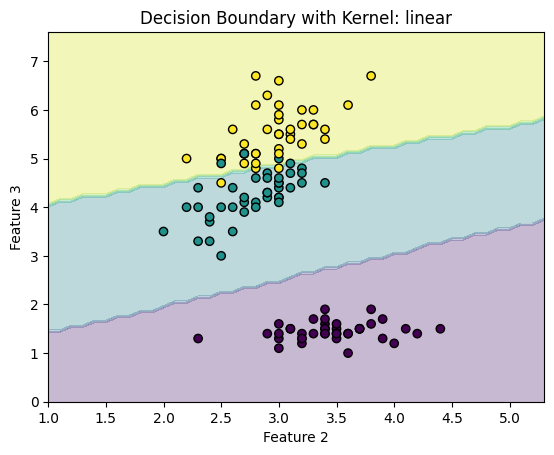

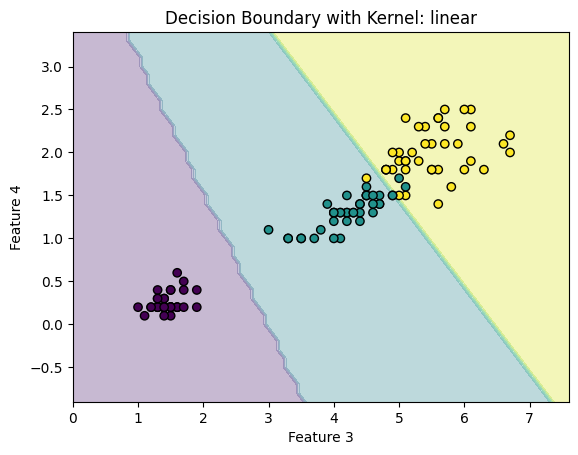

In [152]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, clf, features):
    # Use only specified features
    X = X[:, features]
    
    # Train classifier on reduced feature set
    clf.fit(X, y)
    
    # Generate a grid of points for plotting decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict on each point in the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.xlabel(f"Feature {features[0] + 1}")
    plt.ylabel(f"Feature {features[1] + 1}")
    plt.title(f"Decision Boundary with Kernel: {clf.kernel}")
    plt.show()

# Plot for features 2 vs 3 and 3 vs 4
plot_decision_boundary(X_train, y_train, svm.SVC(kernel=best_kernel), features=[1, 2])
plot_decision_boundary(X_train, y_train, svm.SVC(kernel=best_kernel), features=[2, 3])
